# Short-term temperature forecasting – J+1 prediction (2022)

In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

## Load processed dataset

In [2]:
weather_df = pd.read_csv("data/processed/weather_2022_processed.csv")

weather_df["time"] = pd.to_datetime(weather_df["time"])
weather_df = weather_df.sort_values(["city", "time"])

weather_df.head()

,time,temperature_2m_max,temperature_2m_min,precipitation_sum,city,month,rain_category,hot_category,cold_category,z_temp_max,z_temp_min,z_rain,temp_max_anomaly,temp_min_anomaly,rain_anomaly
5110,2022-01-01,12.9,8.9,0.0,Ajaccio,1,Dry (<1 mm),Normal day (<25°C),Normal night (0-20°C),-1.274027,-0.538014,-0.365737,False,False,False
5111,2022-01-02,13.8,8.4,0.4,Ajaccio,1,Dry (<1 mm),Normal day (<25°C),Normal night (0-20°C),-1.151610,-0.615663,-0.306630,False,False,False
5112,2022-01-03,15.1,8.0,0.1,Ajaccio,1,Dry (<1 mm),Normal day (<25°C),Normal night (0-20°C),-0.974786,-0.677782,-0.350960,False,False,False
5113,2022-01-04,14.4,8.0,1.0,Ajaccio,1,Dry (<1 mm),Normal day (<25°C),Normal night (0-20°C),-1.069999,-0.677782,-0.217968,False,False,False
5114,2022-01-05,13.7,8.7,8.9,Ajaccio,1,Light rain (1-10 mm),Normal day (<25°C),Normal night (0-20°C),-1.165212,-0.569073,0.949402,False,False,False


## Feature engineering – seasonal encoding

In [3]:
weather_df["day_of_year"] = weather_df["time"].dt.dayofyear

weather_df["day_sin"] = np.sin(2 * np.pi * weather_df["day_of_year"] / 365)
weather_df["day_cos"] = np.cos(2 * np.pi * weather_df["day_of_year"] / 365)

## Feature engineering – lag variables (J)

In [4]:
weather_df["temp_max_lag1"] = weather_df.groupby("city")["temperature_2m_max"].shift(1)
weather_df["temp_min_lag1"] = weather_df.groupby("city")["temperature_2m_min"].shift(1)

## Target definition – next day temperature (J+1)

In [5]:
weather_df["target_temp_max_J1"] = weather_df.groupby("city")["temperature_2m_max"].shift(-1)

In [6]:
FEATURES = ["temp_max_lag1", "temp_min_lag1", "day_sin", "day_cos"]
TARGET = "target_temp_max_J1"

## Baseline evaluation (temporal split)

In [7]:
SPLIT_DATE = pd.Timestamp("2022-10-01")

baseline_results = []

for city, city_df in weather_df.groupby("city"):

    city_df = city_df.sort_values("time")

    train = city_df[city_df["time"] < SPLIT_DATE]
    test  = city_df[city_df["time"] >= SPLIT_DATE]

    test = test.dropna(subset=FEATURES + [TARGET])

    y_test = test[TARGET]
    y_pred_naive = test["temp_max_lag1"]

    baseline_results.append({
        "city": city,
        "MAE_baseline": mean_absolute_error(y_test, y_pred_naive),
        "RMSE_baseline": np.sqrt(mean_squared_error(y_test, y_pred_naive))
    })

baseline_df = pd.DataFrame(baseline_results)
baseline_df



,city,MAE_baseline,RMSE_baseline
0,Ajaccio,1.678022,2.248687
1,Besançon,2.820879,3.600168
2,Bordeaux,2.925275,3.679166
3,Clermont-Ferrand,3.231868,4.082810
4,Dijon,2.293407,2.956628
5,Lille,2.023077,2.648470
6,Limoges,2.796703,3.434809
7,Lyon,2.642857,3.531351
8,Marseille,1.703297,2.274706
9,Metz,2.284615,2.965572


## Models comparison

In [8]:
models = {
    "Linear": Pipeline([
        ("scaler", StandardScaler()),
        ("reg", LinearRegression())
    ]),
    "Polynomial_2": Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("reg", LinearRegression())
    ]),
    "Ridge": Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("reg", Ridge(alpha=1.0))
    ])
}


## TimeSeries cross-validation for model stability

In [9]:
cv_results = []

for city, city_df in weather_df.groupby("city"):

    city_df = city_df.sort_values("time")
    city_df = city_df.dropna(subset=FEATURES + [TARGET])

    X = city_df[FEATURES]
    y = city_df[TARGET]

    tscv = TimeSeriesSplit(n_splits=5)

    for model_name, model in models.items():

        maes = []

        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            maes.append(mean_absolute_error(y_test, y_pred))

        cv_results.append({
            "city": city,
            "model": model_name,
            "MAE_mean": np.mean(maes),
            "MAE_std": np.std(maes)
        })

cv_results_df = pd.DataFrame(cv_results)
cv_results_df


,city,model,MAE_mean,MAE_std
0,Ajaccio,Linear,3.609287,2.251486
1,Ajaccio,Polynomial_2,18.864386,22.382039
2,Ajaccio,Ridge,13.937463,14.121777
3,Besançon,Linear,4.021756,1.207943
4,Besançon,Polynomial_2,19.612966,26.403622
5,Besançon,Ridge,16.211819,22.581805
6,Bordeaux,Linear,3.344146,0.654693
7,Bordeaux,Polynomial_2,20.924775,29.101400
8,Bordeaux,Ridge,15.500560,19.817728
9,Clermont-Ferrand,Linear,3.607530,0.890732


## Model Selection

In [10]:
model_performance = (
    cv_results_df
    .groupby("model")["MAE_mean"]
    .mean()
    .sort_values()
)

model_performance


model
Linear           3.322176
Ridge           12.762068
Polynomial_2    19.364613
Name: MAE_mean, dtype: float64

In [11]:
FINAL_MODEL_NAME = model_performance.index[0]
FINAL_MODEL_NAME

'Linear'

## Final model training and evaluation by city

In [12]:
final_results = []
predictions_all = []

for city, city_df in weather_df.groupby("city"):

    city_df = city_df.sort_values("time")

    train = city_df[city_df["time"] < SPLIT_DATE]
    test  = city_df[city_df["time"] >= SPLIT_DATE]

    train = train.dropna(subset=FEATURES + [TARGET])
    test  = test.dropna(subset=FEATURES + [TARGET])

    X_train, y_train = train[FEATURES], train[TARGET]
    X_test,  y_test  = test[FEATURES],  test[TARGET]

    model = clone(models[FINAL_MODEL_NAME])
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    final_results.append({
        "city": city,
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    })

    tmp = test[["time", "city", TARGET]].copy()
    tmp["prediction"] = y_pred
    predictions_all.append(tmp)

final_results_df = pd.DataFrame(final_results)
final_results_df

,city,MAE,RMSE,R2
0,Ajaccio,1.609932,2.069256,0.749821
1,Besançon,3.048626,3.894952,0.629892
2,Bordeaux,2.767837,3.354903,0.703223
3,Clermont-Ferrand,3.586940,4.268274,0.628224
4,Dijon,2.514263,3.137607,0.753122
5,Lille,2.683666,3.363990,0.672208
6,Limoges,2.655149,3.326546,0.709279
7,Lyon,2.904352,3.556940,0.717429
8,Marseille,1.640073,2.060300,0.776571
9,Metz,2.639263,3.227191,0.737450


## Model persistence

In [13]:
# Save trained models (one model per city)

os.makedirs("models", exist_ok=True)

for city, city_df in weather_df.groupby("city"):

    city_df = city_df.sort_values("time")
    city_df = city_df.dropna(subset=FEATURES + [TARGET])

    X = city_df[FEATURES]
    y = city_df[TARGET]

    model = clone(models[FINAL_MODEL_NAME])
    model.fit(X, y)

    joblib.dump(model, f"models/{city}_model.pkl")

print("Models saved in /models")

Models saved in /models


## Visualisation - Best/Median/Worst cities

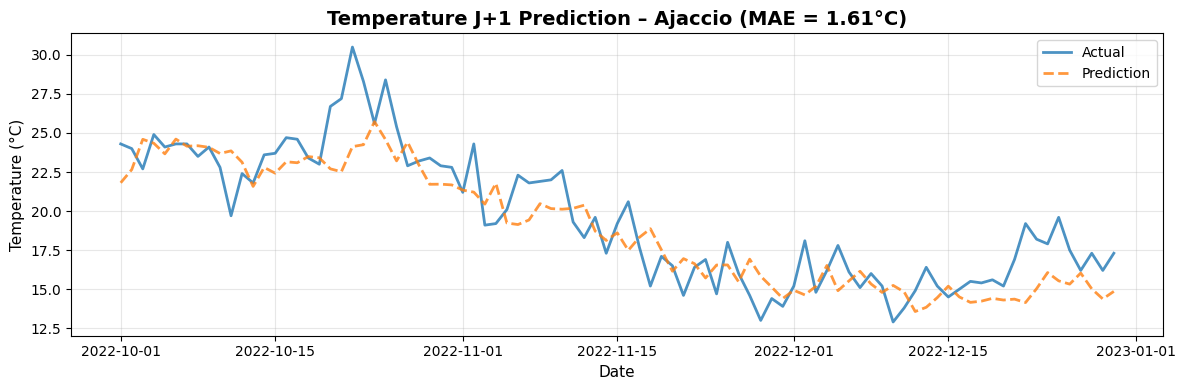

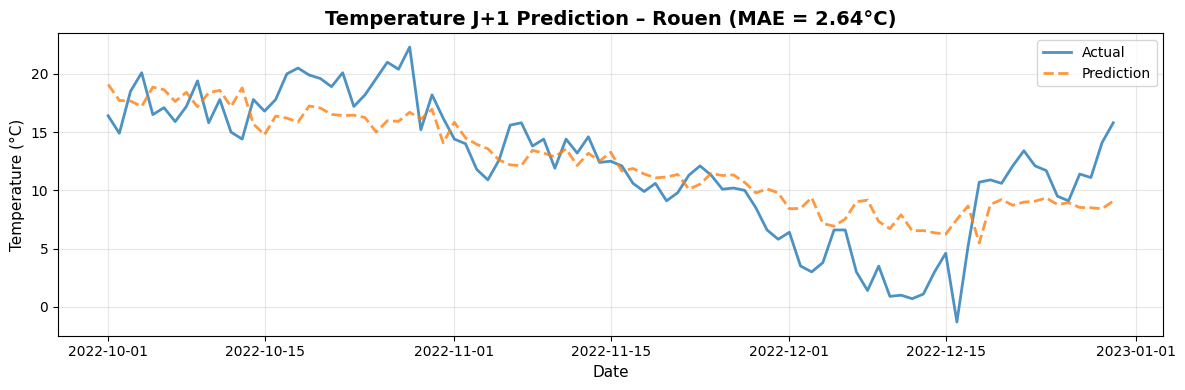

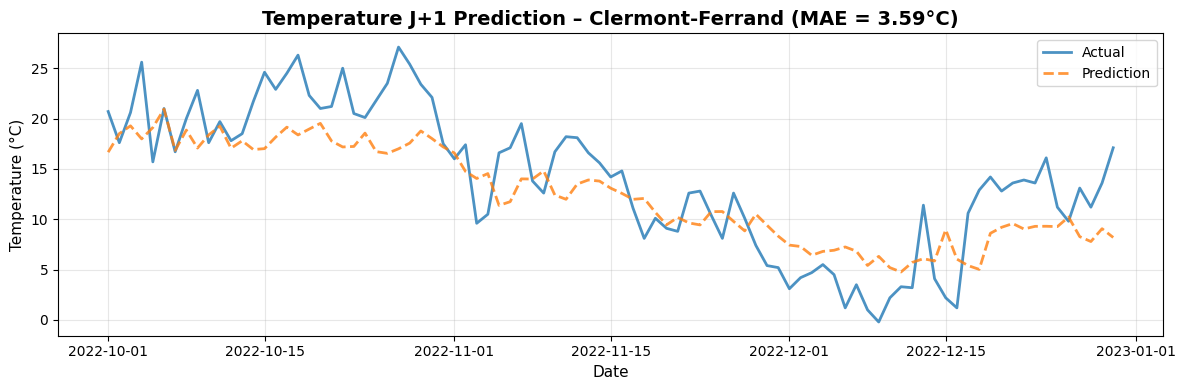

In [14]:
# Concat predictions first
pred_df = pd.concat(predictions_all, ignore_index=True)

# Select representative cities
city_perf = final_results_df.sort_values("MAE")
selected_cities = [
    city_perf.iloc[0]["city"],                    # best
    city_perf.iloc[len(city_perf)//2]["city"],    # median
    city_perf.iloc[-1]["city"]                    # worst
]

# Plot for each selected city
for city in selected_cities:
    city_data = pred_df[pred_df["city"] == city]
    mae_value = final_results_df[final_results_df["city"] == city]["MAE"].values[0]
    
    plt.figure(figsize=(12, 4))
    plt.plot(city_data["time"], city_data[TARGET], label="Actual", alpha=0.8, linewidth=2)
    plt.plot(city_data["time"], city_data["prediction"], label="Prediction", alpha=0.8, linewidth=2, linestyle='--')
    
    plt.title(f"Temperature J+1 Prediction – {city} (MAE = {mae_value:.2f}°C)", fontsize=14, fontweight='bold')
    plt.xlabel("Date", fontsize=11)
    plt.ylabel("Temperature (°C)", fontsize=11)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    plt.close()


In [15]:
summary_df = baseline_df.merge(final_results_df, on="city", how="inner")

summary_df["MAE_gain_vs_baseline"] = (
    (summary_df["MAE_baseline"] - summary_df["MAE"]) / summary_df["MAE_baseline"]
)

summary_df

,city,MAE_baseline,RMSE_baseline,MAE,RMSE,R2,MAE_gain_vs_baseline
0,Ajaccio,1.678022,2.248687,1.609932,2.069256,0.749821,0.040577
1,Besançon,2.820879,3.600168,3.048626,3.894952,0.629892,-0.080736
2,Bordeaux,2.925275,3.679166,2.767837,3.354903,0.703223,0.053820
3,Clermont-Ferrand,3.231868,4.082810,3.586940,4.268274,0.628224,-0.109866
4,Dijon,2.293407,2.956628,2.514263,3.137607,0.753122,-0.096301
5,Lille,2.023077,2.648470,2.683666,3.363990,0.672208,-0.326527
6,Limoges,2.796703,3.434809,2.655149,3.326546,0.709279,0.050615
7,Lyon,2.642857,3.531351,2.904352,3.556940,0.717429,-0.098944
8,Marseille,1.703297,2.274706,1.640073,2.060300,0.776571,0.037118
9,Metz,2.284615,2.965572,2.639263,3.227191,0.737450,-0.155233


## Prediction vs actual temperature

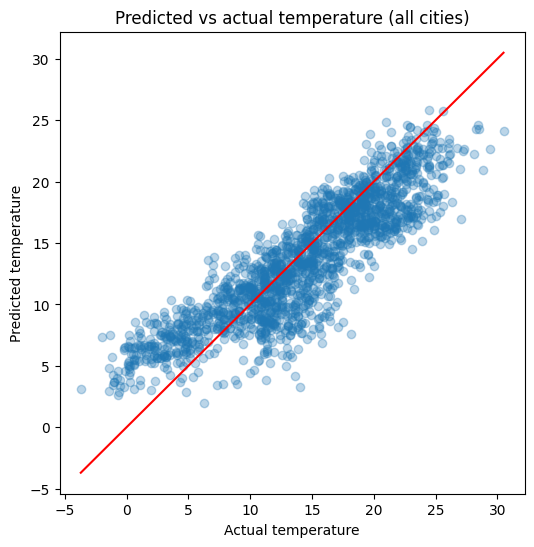

In [16]:
plt.figure(figsize=(6, 6))
plt.scatter(pred_df[TARGET], pred_df["prediction"], alpha=0.3)

min_val = min(pred_df[TARGET].min(), pred_df["prediction"].min())
max_val = max(pred_df[TARGET].max(), pred_df["prediction"].max())

plt.plot([min_val, max_val], [min_val, max_val], color="red")
plt.xlabel("Actual temperature")
plt.ylabel("Predicted temperature")
plt.title("Predicted vs actual temperature (all cities)")
plt.show()
plt.close()


## Save predictions for application

In [17]:
os.makedirs("data/predictions", exist_ok=True)

pred_df.to_csv("data/predictions/weather_predictions_2022_J1.csv", index=False)

print("Predictions saved to data/predictions/weather_predictions_2022_J1.csv")

Predictions saved to data/predictions/weather_predictions_2022_J1.csv
